In [1]:
from segmenter_api.utils.file import get_project_dir

%cd {get_project_dir()}
print(get_project_dir())

/home/yoshino_teppei/ghq/github.com/Tyaba/segmenter-api
/home/yoshino_teppei/ghq/github.com/Tyaba/segmenter-api


In [ ]:
from pathlib import Path

import torch
from PIL import Image
from transformers import AutoModelForCausalLM, AutoProcessor


In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Florence-2-large", torch_dtype=torch_dtype, trust_remote_code=True
).to(device)
processor = AutoProcessor.from_pretrained(
    "microsoft/Florence-2-large", trust_remote_code=True
)

/home/yoshino_teppei/ghq/github.com/Tyaba/segmenter-api/.venv/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [5]:
task_prompt = "<OPEN_VOCABULARY_DETECTION>"
text_input = "cosmetics"
image_path = Path("data/multiple_products.png")
image = Image.open(image_path).convert("RGB")
prompt = f"{task_prompt}{text_input}"

In [6]:
inputs = processor(text=prompt, images=image, return_tensors="pt").to(
    device, torch_dtype
)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=4096,
    num_beams=3,
    do_sample=False,
)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

In [7]:
parsed_answer = processor.post_process_generation(
    generated_text,
    task=task_prompt,
    image_size=(image.width, image.height),
)

print(parsed_answer)


{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[587.4000244140625, 66.2540054321289, 748.2000122070312, 561.7460327148438]], 'bboxes_labels': ['cosmetics'], 'polygons': [], 'polygons_labels': []}}


In [10]:
parsed_answer["<OPEN_VOCABULARY_DETECTION>"]

{'bboxes': [[587.4000244140625,
   66.2540054321289,
   748.2000122070312,
   561.7460327148438]],
 'bboxes_labels': ['cosmetics'],
 'polygons': [],
 'polygons_labels': []}

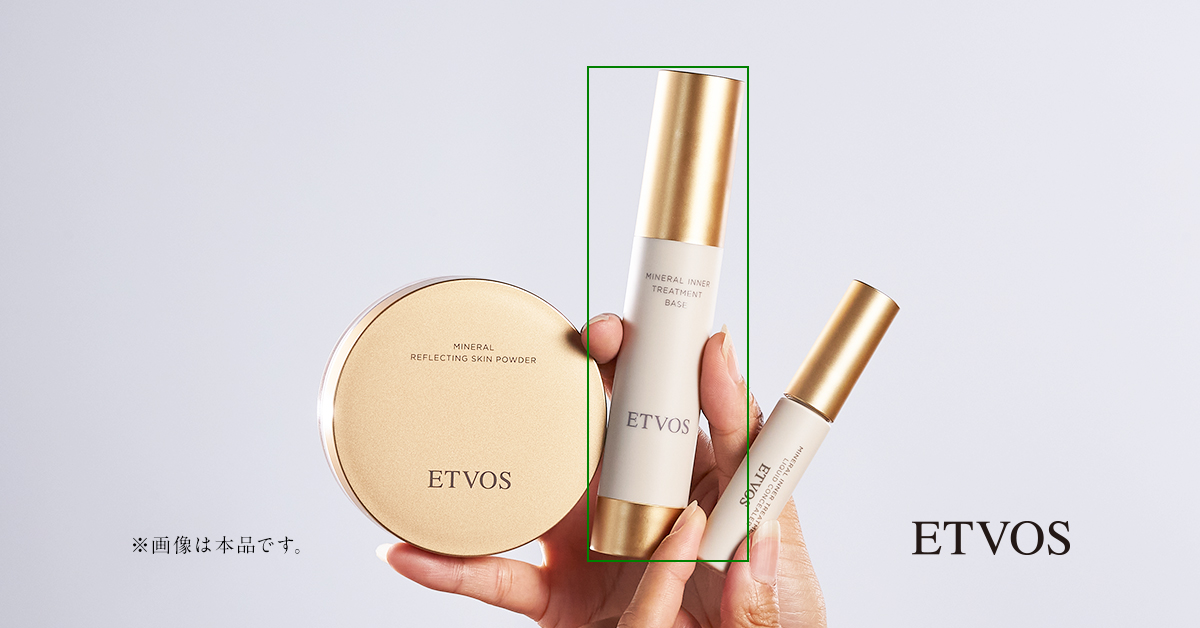

In [9]:
draw_bboxes(
    image=image,
    bboxes=parsed_answer["<OPEN_VOCABULARY_DETECTION>"]["bboxes"],
    color="green",
)
